#### Lower Triangular Factorised Block Matrix

In [1]:
import sys
import time
import numpy as np
import nexpy as nxp
from IPython.display import display
from scipy.sparse import csr_matrix

In [2]:
# SECTION : SUBSECTION
    # (markdown introduction)
    # METHODS : DESCRIPTION
    # PARAMETERS : DESCRIPTION
    # COMPUTATIONS : DESCRIPTION
    # OUTPUTS : DESCRIPTION

In [3]:
# Important Note: In the runtime_stat method one can change the for the ltfbm matrix-vector product the deep compatible boolean.
# If it is set to True, "mat_ltfbm.dot(vec, deep_compatible=True)" takes the matrix-vector product designed for deep compatible tiling and fully factorised matrices.
# If it is set to False, "mat_ltfbm.dot(vec, deep_compatible=False)" takes the matrix-vector product designed for only "simple" compatible tiling and factorised matrices.

#### Experiments

In [4]:
# METHODS: construction, storage and runtime statistics

def construction_stat(tiling):

    res = [] 
    
    # Generate pseudo random ltfbm
    mat_ltfbm, end = nxp.random_utils.ltfbm(
        tiling=tiling,
        monitoring=True)

    res.append(end)

    # Reconstruction
    A = mat_ltfbm.reconstruct(max_depth=np.infty).reconstruct()

    # Construction of SciPy csr (compressed sparse row) matrix 
    start = time.time()
    mat_csr = csr_matrix(A)
    res.append((time.time()-start)*1e3)

    # Construction of NumPy array
    start = time.time()
    mat_np = np.tril(A, k=0)
    res.append((time.time()-start)*1e3)

    # Return matrices and results
    return mat_ltfbm, mat_csr, mat_np, np.array(res)


def storage_stat(mat_ltfbm, mat_csr, mat_np):
    # [FactorisedRowMajorOrdering, csr_matrix, np.array]
    res = [] 
    
    # Compute storage sizes
    res.append(sys.getsizeof(mat_ltfbm) + mat_ltfbm.bytes)
    res.append(sys.getsizeof(mat_csr) + mat_csr.data.nbytes + mat_csr.indices.nbytes + mat_csr.indptr.nbytes)
    res.append(sys.getsizeof(mat_np))
    
    # Return results
    return np.array(res)

def runtime_stat(mat_ltfbm, mat_csr, mat_np, vec):
    
    # [FactorisedRowMajorOrdering, csr_matrix, np.array]
    res = [] 
    
    # Run ltfbm compatible matrix-vector product
    start_time = time.time()
    mat_ltfbm.dot(vec, deep_compatible=False)
    res.append((time.time() - start_time)*1e3)
    
    # Run SciPy CSR matrix-vector product
    start_time = time.time()
    mat_csr.dot(vec)
    res.append((time.time() - start_time)*1e3)
    
    # Run NumPy array matrix-vector product
    start_time = time.time()
    mat_np.dot(vec)
    res.append((time.time() - start_time)*1e3)
    
    # Return results
    return np.array(res)

In [5]:
# METHODS : statistics handler

def stat_handler(mat_sizes: np.array, rand_int_lists, I = 5):
    # I ... the amount of iterations averaged in each step referring mv-products
    
    # Length of mat_sizes
    l = len(mat_sizes)
    
    # Display empty progress bar
    pb = display(nxp.visual.html.progress_bar(0), display_id=True)
    
    # Initialise statistics
    avg_runtimes_c, avg_storages, avg_runtimes = np.zeros((3, l, 3)) 
    var_runtimes = np.zeros((l, 3)) 
    
    # Total amount of random integer lists 
    total_amount = 0

    for j, n in enumerate(mat_sizes):
        for rand_int_list in rand_int_lists[j]:
            # Add to total amount
            total_amount += len(rand_int_lists[j])
            
            # Initilialise runtime_c dummy
            runtime_c = np.zeros((I, 3))
            
            # Add construction time to statistics
            mat_ltfbm, mat_csr, mat_np, runtime_c = construction_stat(rand_int_list)
            avg_runtimes_c[j] += runtime_c
            
            # Initiliase storage dummy
            storage = np.zeros((I, 3))
            
            # Add storage to statistics
            storage = storage_stat(mat_ltfbm, mat_csr, mat_np)
            avg_storages[j] += storage
            
            # Initialise runtime dummy
            runtime = np.zeros((I, 3))

            # Compute the matrix vector product
            for i in range(I):

                # Generate np pseudo random vector
                vec = np.random.rand(n)

                # Run matrix-vector products
                runtime[i] = runtime_stat(mat_ltfbm, mat_csr, mat_np, vec)

            # Compute median, add to averaged runtimes and compute variance (without scale) to statistics
            runtime_median = np.median(runtime, axis=0)
            avg_runtimes[j] += runtime_median
            var_runtimes[j] += np.median((runtime-np.array([runtime_median]*I))**2, axis=0)
        
        # Update progress bar
        progress = int(100*(j + 1)/l)
        pb.update(nxp.visual.html.progress_bar(progress))
        
    avg_runtimes_c /= total_amount
    avg_storages /= total_amount
    avg_runtimes /= total_amount
    var_runtimes /= total_amount
        
    return avg_runtimes_c, avg_storages, avg_runtimes, var_runtimes

In [6]:
# PARAMETERS
I = 100
captures = ["LTFBM", "SciPy CSR", "NumPy"]
depths, ns = [2]*I, [j for j in range(60, 160)]
print(f"depths={depths}, n's={ns}")
rand_int_lists = [
    nxp.random_utils.deep_compatible_integer_list(depth=depths[idx], n=ns[idx])
    for idx in range(I)]
mat_sizes = np.array([
    it_r.size
    for it_r in rand_int_lists])
argsort = np.argsort(mat_sizes)
rand_int_lists = [[it_r] for it_r in np.take(rand_int_lists, argsort)]
mat_sizes = np.take(mat_sizes, argsort)
print(f"mat sizes = {mat_sizes}")

# Alternative: 
# Define: mat_sizes = np.array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150])
# nxp.random_utils.uncertain_integer_lists(n=n, total_amount=25000, min_depth=2, max_depth=10, compatible=True) for n in mat_sizes]

ril_var_scale = 1.0
var_scale = 1.0

depths=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], n's=[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
mat sizes = [  123   127   131   147   163   171   171   173   179   183   209   211
   215   221   223   227   229   230   233   237   251   255   259   265
   276   279   281   282   287   303   305   319   445   465   473  

In [8]:
# COMPUTATIONS: runtime and storage stat

avg_runtimes_c, avg_storages, avg_runtimes, var_runtimes= stat_handler(mat_sizes, rand_int_lists)

In [9]:
# COMPUTATION: Prepare variance plot

var_upper_runtimes = avg_runtimes + var_scale*var_runtimes
var_lower_runtimes = avg_runtimes - var_scale*var_runtimes

In [10]:
# COMPUTATION: Characteristics of random integer lists

ril_len = [len(tilings) for tilings in rand_int_lists]
ril_mean = np.array([np.mean([itt.depth() for itt in itr]) for itr in rand_int_lists])
ril_var = np.array([
    np.mean((itm*np.ones(ril_len[idm]) - np.array([itr.depth() for itr in rand_int_lists[idm]]))**2)
    for idm, itm in enumerate(ril_mean)])
ril_var_upper = ril_mean + ril_var_scale*ril_var
ril_var_lower = ril_mean - ril_var_scale*ril_var

In [11]:
# OUTPUTS: Matrix sizes and random tilings length

print(f'len={len(mat_sizes)}, data={mat_sizes}')
print(f'len={len(rand_int_lists)}, map={ril_len}')

len=100, data=[  123   127   131   147   163   171   171   173   179   183   209   211
   215   221   223   227   229   230   233   237   251   255   259   265
   276   279   281   282   287   303   305   319   445   465   473   511
   594   712  1025  1163  1391  1651  1850  1878  1987  2412  2556  2628
  2794  2850  3003  3329  3721  3916  4225  4371  4465  4624  4729  4857
  4900  5050  5491  5698  5995  6400  6603  7260  7636  7750  7955  8100
  8281  8778  9604 10153 10404 10502 10731 10878 11026 11175 11427 11801
 11935 12100 12769 13662 14659 14873 15282 15625 17956 19330 19508 20971
 22096 22391 22500 23259]
len=100, map=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


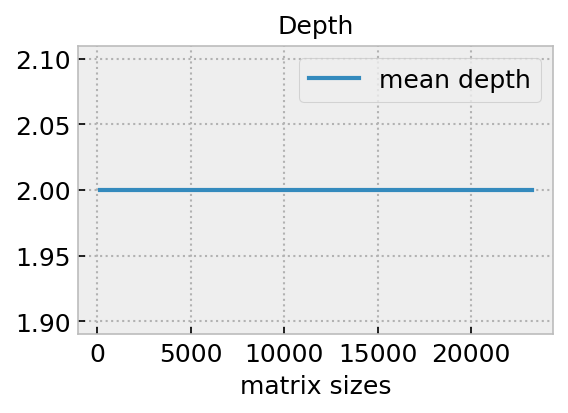

In [12]:
# Outputs: Random integer lists mean depth plot
# NOTE THAT: The implementation depth = actual depth + 1 --> implementation issue
nxp.visual.plot.experiment(
    xticks   = mat_sizes,
    plots    =[{'data': ril_mean,
                'sigma_upper':ril_var_upper,
                'sigma_lower':ril_var_lower,
                'label': 'mean depth'} ],
    title    ='Depth',
    xlabel   ='matrix sizes',
    ylabel   ='',
    markers  =False,
    max_ratio=False)

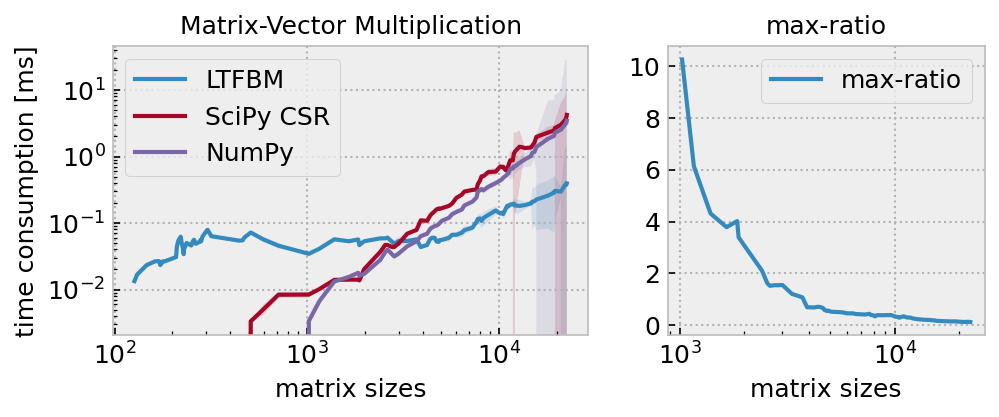

In [13]:
# OUTPUTS : Experiment plot averaged runtime

# Applying a moving average with a fixed window size

window_size = 3
side_cut_off = int((window_size-1)/2)

ma_avg_runtimes = np.array([nxp.utils.moving_average(ita, window_size).tolist() for ita in avg_runtimes.T])
ma_var_upper_runtimes = np.array([nxp.utils.moving_average(itv, window_size).tolist() for itv in var_upper_runtimes.T])
ma_var_lower_runtimes = np.array([nxp.utils.moving_average(itv, window_size).tolist() for itv in var_lower_runtimes.T])


nxp.visual.plot.experiment(
    xticks   = mat_sizes[side_cut_off:-side_cut_off],
    plots    =[{'data': ma_avg_runtimes[ida],
                'sigma_upper': ma_var_upper_runtimes[ida],
                'sigma_lower': ma_var_lower_runtimes[ida],
                'label': capture} for ida, capture in enumerate(captures)],
    title    ='Matrix-Vector Multiplication',
    xlabel   ='matrix sizes',
    ylabel   ='time consumption [ms]',
    xlabelrot=0,
    markers  =False,
    ylogscale=True,
    xlogscale=True)

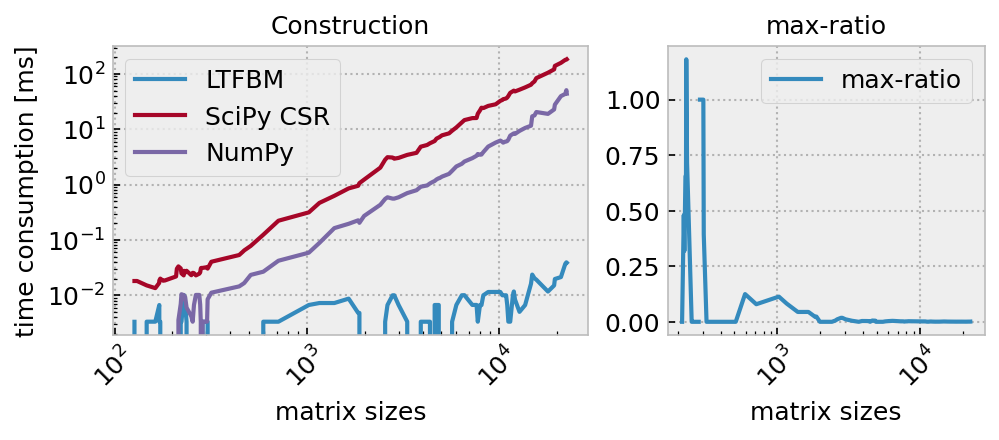

In [14]:
# OUTPUTS: Experiment plot of averaged construction runtime

# Applying a moving average with a fixed window size

window_size = 3
side_cut_off = int((window_size-1)/2)

ma_avg_runtimes_c = np.array([nxp.utils.moving_average(ita, window_size).tolist() for ita in avg_runtimes_c.T])

nxp.visual.plot.experiment(
    xticks   =mat_sizes[side_cut_off:-side_cut_off],
    plots    =[{'data': ma_avg_runtimes_c[ida], 'label': capture}  for ida, capture in enumerate(captures)],
    title    ='Construction',
    xlabel   ='matrix sizes',
    ylabel   ='time consumption [ms]',
    xlabelrot=45,
    markers  =False,
    ylogscale=True,
    xlogscale=True)

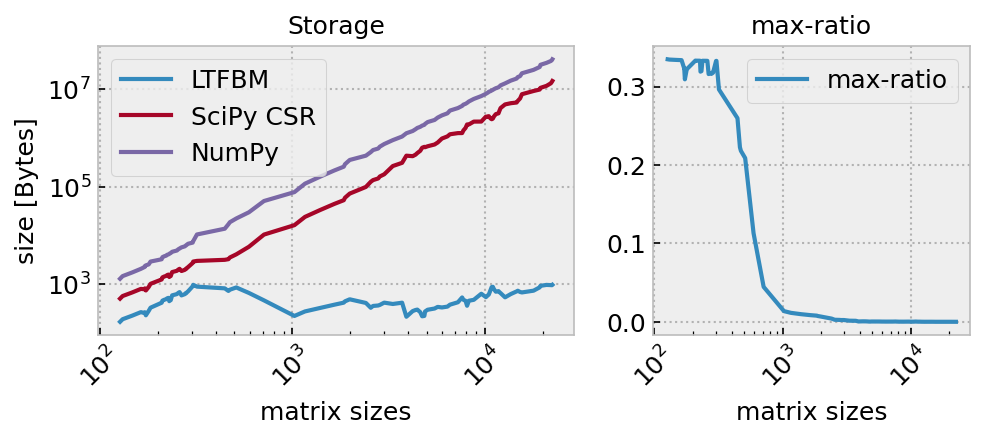

In [15]:
# OUTPUTS: Experiment plot averaged storage

# Applying a moving average with a fixed window size

window_size = 3
side_cut_off = int((window_size-1)/2)

ma_avg_storages = np.array([nxp.utils.moving_average(ita, window_size).tolist() for ita in avg_storages.T])

nxp.visual.plot.experiment(
    xticks   =mat_sizes[side_cut_off:-side_cut_off],
    plots    =[{'data': ma_avg_storages[ida], 'label': capture}  for ida, capture in enumerate(captures)],
    title    ='Storage',
    xlabel   ='matrix sizes',
    ylabel   ='size [Bytes]',
    xlabelrot=45,
    markers  =False,
    ylogscale=True,
    xlogscale=True)